# SG VRN analysis

A **vehicle registration number (VRN)** is a 4-digit number that is used as an identifier on a car. To some, this is just another inconsequential number, akin to one's passport number, credit card number or membership number of some programme.

But to others, this number is of crucial importance and an item that they would be happy to shell out thousands of dollars, or even tens of thousands of dollars for. This is probably especially pertinent for Chinese people, given their fascination for auspicious numbers (e.g. 8, which sounds like 发, which represents prosperity) and likewise, their antipathy towards inauspicious numbers (e.g. 4, which sounds like 死, which represents death).

The Land Transport Authority of Singapore (LTA) holds bidding exercises for these plate numbers for each letter series, e.g. SMS, SMT. For every series, 1- and 2-digit numbers are always snapped up due to their rarity (2-digit numbers constitute 0.9% of the total number pool, while 1-digit numbers constitute 0.1%). Another reason to bid for a number is to represent personal milestones/occasions as well, e.g. phone number, date of marriage, birth year. Or, it can simply be for *fengshui* reasons.

These bids are priced at a minimum of $1,000, although it will most likely require a 5-digit number to secure a prized number. A quick trip to the sgCarMart number plate marketplace shows plates being listed from prices ranging from a low 4-digit figure to a whopping 6-digit figure.

This set me thinking - **which number is the most desirable**? Is number 8 the most popular due to its auspiciousness, and is number 4 indeed unpopular? If 8 is desirable, what about 88, 888 or 8888?

As data on successful bid prices for each number is not publicly available, it is not that straightforward of a task to quantify this.

Instead, I can attempt to rephrase this question to "**which number plate has the highest value?**" - this will be calculated by finding the *mean value of all the cars possessing a certain number plate*. This is not a perfect metric by any means, but it might be possible to derive some notable insights from this analysis.

## Identifying notable numbers

First, I identified some notable numbers that are typically viewed as "desirable" numbers. This is a preliminary list for now; more numbers might continue to be added in the future.

Number list:

    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 18, 28, 88, 99, 100, 888, 999, 8888
    
As of the time of writing, the following letter series have been covered.

```
SKF, SKG, SKH, SKJ, SKK, SKL, SKM, SKN, SKP, SKQ, SKR, SKS, SKT, SKU, SKV, SKW, SKX, SKZ
SLA, SLB, SLC, SLD, SLE, SLF, SLG, SLH, SLJ, SLK, SLL, SLM, SLN, SLP, SLQ, SLR, SLS, SLT, SLU, SLV, SLW, SLX, SLZ
SMA, SMC, SMD, SME, SMF, SMG, SMH, SMJ, SMK, SML, SMN, SMP, SMQ, SMR, SMS
```

Hence, there are a maximum of **18 \* 56 = 1008** data points in this dataset. Not all of the plate combinations have a registered car, so the eventual number of data points will be slightly less.

## Collecting the data

There were 2 sets of data that had to be collected:

1. List of car models possessing a number plate
1. Monetary value of each of these car models

For each number plate combination, I had to identify the checksum letter, or the last letter of the number plate. Fortunately, this information could be easily found online. Then, finding the **car model for a particular number plate** could be done via [LTA's road tax expiry enquiry site](https://vrl.lta.gov.sg/lta/vrl/action/pubfunc2?ID=EnquireRoadTaxExpDtProxy).

Quantifying the **value of each car model** was not an easy task and might not be wholly accurate, especially given the dynamic nature of the COE price and the myriad of car models of varying generations, as well as the lack of a listed price for some super high-end car brands. Nevertheless, it should serve as a decent approximation.

The data collection process is explained in more detail in the accompanying [**ETL pipeline**](https://nbviewer.jupyter.org/github/ruibinch/vrn-analysis/blob/master/notebooks/ETL%20pipeline.ipynb) notebook.

The repository for all collected data can be found in a [Google Sheets](https://docs.google.com/spreadsheets/d/1SjCxfvHsLSk2Yh-AFGY2c1YOsvFybGRvZOuU_uaNuVY/) document.

## Analysing the data

After the requisite data has been collected, the data analysis phase can then commence.

There are 3 datasets produced from the data collection phase:

1. `VRNCleaned` - dataset of car models for each number plate
1. `Prices` - mapping of each car model to price
1. `Results` - dataset of car prices for each number plate; a result of combining the above 2 datasets

### Loading the datasets

In [1]:
# set pwd to root folder of repository
import os
while not os.getcwd().endswith('vrn-analysis'):
    os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import graph

# graph options
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (18, 7)

In [2]:
%%html
<style>
table {float:left}
</style>

#### `VRNCleaned` dataset

| Feature | Description |
| :--- | :--- |
| Row | Letter series |
| Column | Plate number |
| Cell | Car model possessing that VRN |

In [3]:
df_vrn = pd.read_csv('./data/SG VRN Analysis - VRNCleaned.csv')
df_vrn.set_index('Series', inplace=True)
df_vrn.head(3)

,1,2,3,4,5,6,7,8,9,10,18,28,88,99,100,888,999,8888
Series,,,,,,,,,,,,,,,,,,
SKF,ROLLS ROYCE / PHANTOM,MAZDA / ROADSTER 1.5,LAMBORGHINI / AVENTADOR LP700-4,MERCEDES BENZ / 280S,PORSCHE / PANAMERA,SUZUKI / SWIFT HYBRID 1.2,FERRARI / 458 SPIDER 4.5,PORSCHE / 911 CARRERA,TOYOTA / ALPHARD 2.5 S-C,-,B.M.W. / X6 XDRIVE35I,B.M.W. / 520I,VOLKSWAGEN / GOLF 1.4,MERCEDES BENZ / GLC250 4MATIC,TOYOTA / LEXUS RX350,BENTLEY / CONTINENTAL FLYING SPUR,NISSAN / GT-R 3.8,MERCEDES BENZ / V250
SKG,ROLLS ROYCE / GHOST EWB,B.M.W. / X2 SDRIVE18I M-SPORT,MERCEDES BENZ / C200 AMG COUPE,MERCEDES BENZ / C180 AVANTGARDE,MINI / COOPER S COUNTRYMAN,B.M.W. / X3 SDRIVE20I,MERCEDES BENZ / AMG G63 4MATIC,BENTLEY / CONTINENTAL GT V8,MERCEDES BENZ / E200 AVANTGARDE,B.M.W. / 730I M-SPORT,B.M.W. / 750LI,TOYOTA / CAMRY 2.4,MERCEDES BENZ / AMG C43 4MATIC,-,TOYOTA / NOAH 2.0 X,TOYOTA / LEXUS CT200H,HONDA / VEZEL HYBRID 1.5,TOYOTA / ALPHARD 2.5 S-C
SKH,-,PORSCHE / MACAN S II,MERCEDES BENZ / C180 AVANTGARDE,-,MERCEDES BENZ / S500L AMG,AUDI / A4 2.0,MERCEDES BENZ / GL450,-,FERRARI / 488 GTB,B.M.W. / 740LI,TOYOTA / HARRIER 2.4,MASERATI / GRANCABRIO SPORT,B.M.W. / X3 SDRIVE20I,-,B.M.W. / 730LI,B.M.W. / 528I,TOYOTA / VELLFIRE 2.5,TOYOTA / ALPHARD 2.5 ELEGANCE


#### `Prices` dataset

Each row represents the detail of a car model, divided into 3 factors - make, model, price.

In [4]:
df_prices = pd.read_csv('./data/SG VRN Analysis - Prices.csv')
df_prices.replace(',', '', inplace=True, regex=True)
df_prices['Price'] = pd.to_numeric(df_prices['Price']) # convert "Price" col to numeric type
df_prices.head(3)

,Make,Model,Price
0,ALFA ROMEO,GIULIA 2.9 V6,339000
1,ALPINA,B3 BITURBO,318800
2,ALPINE,A110,238800


#### `Results` dataset

| Feature | Description |
| :--- | :--- |
| Row | Letter series |
| Column | Plate number |
| Cell | Price of the car model possessing that VRN |

In [5]:
df_results = pd.read_csv('./data/SG VRN Analysis - Results.csv')
df_results.set_index('Series', inplace=True)
df_results.replace('^MISSINGPRICE:.*|-', np.NaN, inplace=True, regex=True) # replace empty values or missing prices
df_results = df_results.apply(pd.to_numeric) # convert all cols to numeric type
df_results.head(3)

,1,2,3,4,5,6,7,8,9,10,18,28,88,99,100,888,999,8888
Series,,,,,,,,,,,,,,,,,,
SKF,1778888.0,148000.0,1588000.0,158888.0,370388.0,84800.0,1291000.0,478788.0,192000.0,NaN,353888.0,240888.0,98900.0,224888.0,287800.0,730000.0,590000.0,278888.0
SKG,1600000.0,166888.0,227888.0,182888.0,168888.0,210888.0,676888.0,912000.0,249888.0,411888.0,594888.0,146888.0,347888.0,NaN,112888.0,179000.0,90000.0,192000.0
SKH,NaN,288788.0,182888.0,NaN,584888.0,188016.0,442888.0,NaN,995000.0,461888.0,144888.0,608800.0,210888.0,NaN,400888.0,250888.0,207888.0,225888.0


### Analysis

#### Which plate number has the highest value?

This is the golden question that sparked this entire project.

Note that the relationship between the value and desirability of a plate number is a bit murky. A plate number with a higher value does not necessarily imply that it is more desirable; it might just mean that more people with expensive cars favour that number.

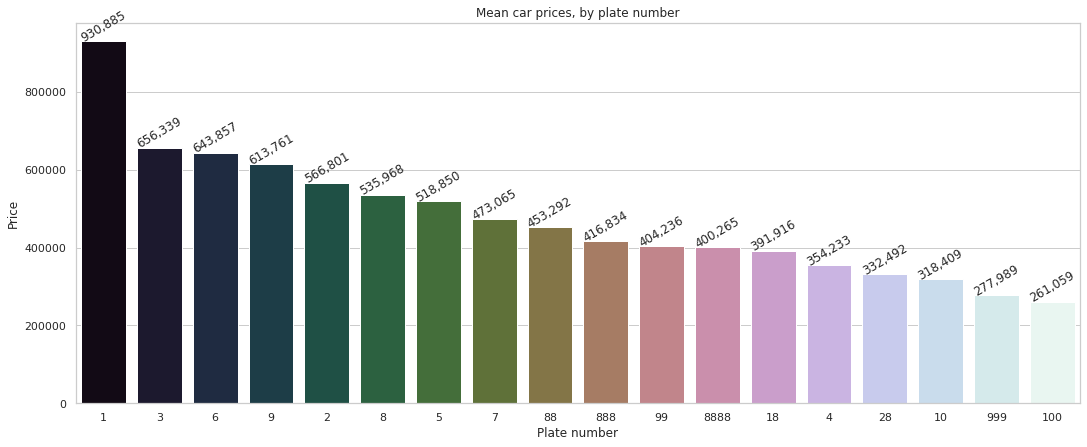

In [6]:
means = df_results.mean().sort_values(ascending=False)
ax = sns.barplot(means.index, means.values, order=means.index, palette='cubehelix')
ax.set(
    title='Mean car prices, by plate number',
    xlabel='Plate number',
    ylabel='Price')
graph.show_values_on_bars(ax, 'v')

We can note some observations from the graph:

- 1 has the highest value by far - perhaps we can loosely conclude that the number 1 is a general preferred choice for people with high-end cars
- Single-digit numbers rank at the top
- There are several other single-digit numbers that have a higher value than the auspicious 8
- More 8s in the number plate do not correlate with an increase in value
- 4 ranks the lowest by far among the single-digit numbers - there might be some correlation between value and desirability after all (for some numbers at least)

#### What is the distribution of car prices for each plate number?

Let us look at the **distribution** of prices of the individual cars for each plate number.

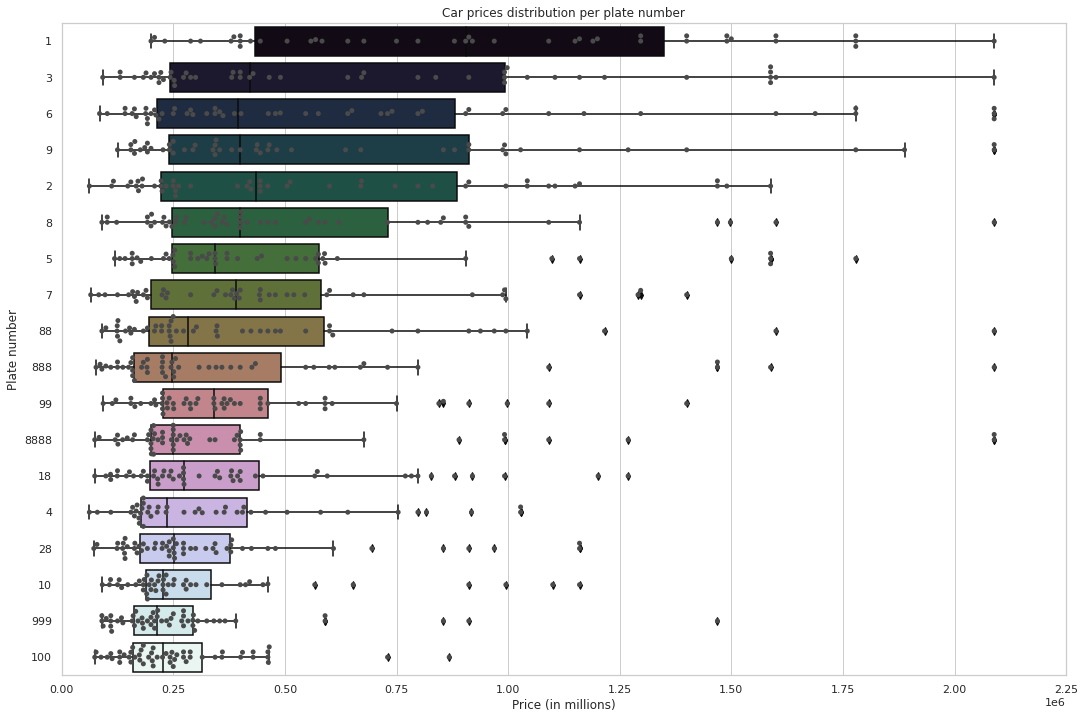

In [7]:
# sort DF cols by descending order of means
df_results_sorted = df_results \
    .reindex(df_results.mean().sort_values(ascending=False).index, axis=1)

fig, ax = plt.subplots(figsize=(18, 12))
sns.boxplot(data=df_results_sorted, palette='cubehelix', orient='h', ax=ax)
sns.swarmplot(data=df_results_sorted, color='#4A4A4A', orient='h', ax=ax)
ax.set(
    title='Car prices distribution per plate number',
    xlabel='Price (in millions)',
    ylabel='Plate number',
    xlim=[0, 2250000],
    xticks=np.arange(0, 2500000, step=250000));

- The most expensive car - *ROLLS ROYCE PHANTOM EWB* - has a price tag of ~\\$2.1m that is so ridiculously high that it skews the data slightly
    - Although, this will be chump change if the dataset includes the ~\\$7m *KOENIGSEGG AGERA RS* or the ~\\$4.5m *MCLAREN SENNA*
- It is interesting to note that aside from the top 4 most popular numbers, this *ROLLS ROYCE PHANTOM EWB* only appears for the plate numbers 8, 88, 888, 8888
- The magical number 1 only has 3 cars that cost less than the quarter-million mark - 2 *TOYOTA VELLFIRE* and 1 *BMW 420i COUPE*. They are practically peasant cars.

#### Which letter series has the highest value?

It is unlikely that significant useful insights can be derived from this analysis, unless the high-value *letter series* are part of the dataset - these will refer to single- or double-letter combinations like S, SP, EF due to their rarity nowadays.

But, since the data is already provided, why not plot it out on a graph?

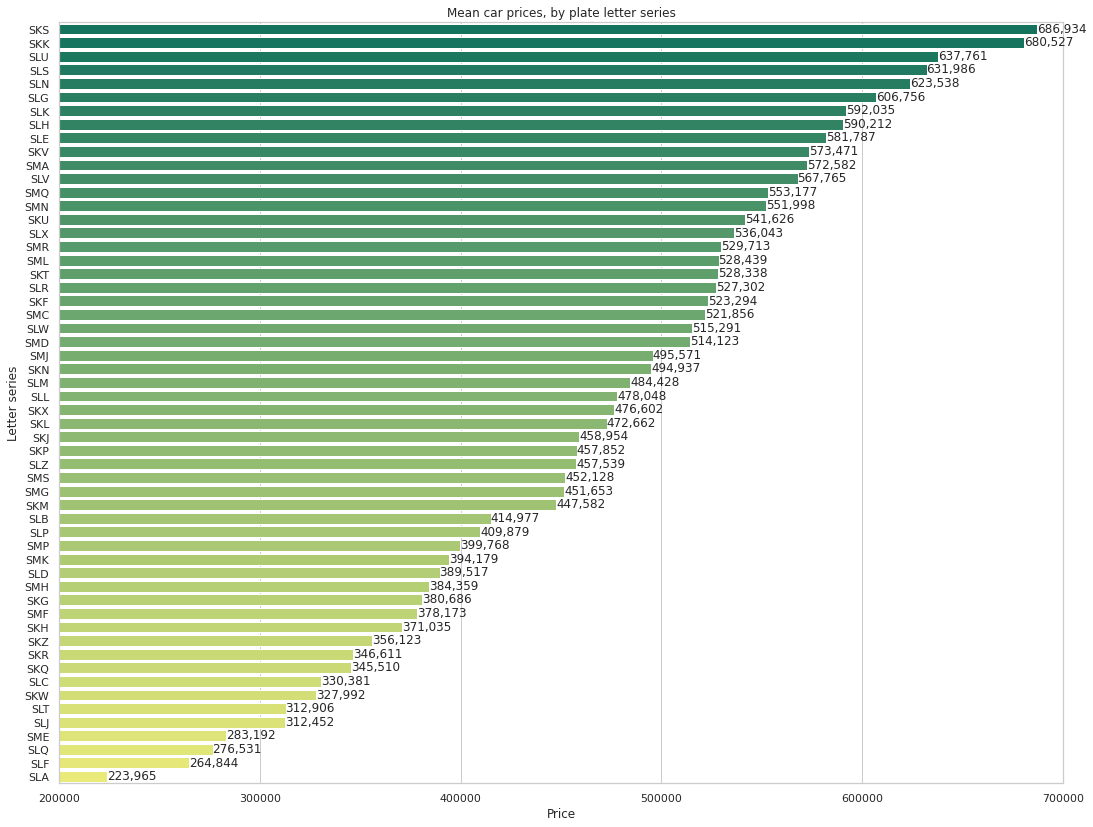

In [8]:
means_by_letter = df_results.mean(axis=1).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(18, 14))
sns.barplot(
    means_by_letter.values,
    means_by_letter.index,
    orient='h',
    palette='summer',
    ax=ax)
ax.set(
    title='Mean car prices, by plate letter series',
    xlabel='Price',
    ylabel='Letter series',
    xlim=[200000, 700000],
    xticks=np.arange(200000, 800000, step=100000))
graph.show_values_on_bars(ax, 'h')

Although there seems to be a large difference, it is more likely due to the dataset being small (only 18 data points for each letter series) and being easily skewed by a couple of multi-million dollar cars.

#### Which are the most expensive car models?

It is evident that *ROLLS ROYCE PHANTOM EWB* is the undisputed champion here - one could buy 3 *BENTLEY CONTINENTAL GT* with it.

Let us see which are the other car models that come in the top 15.

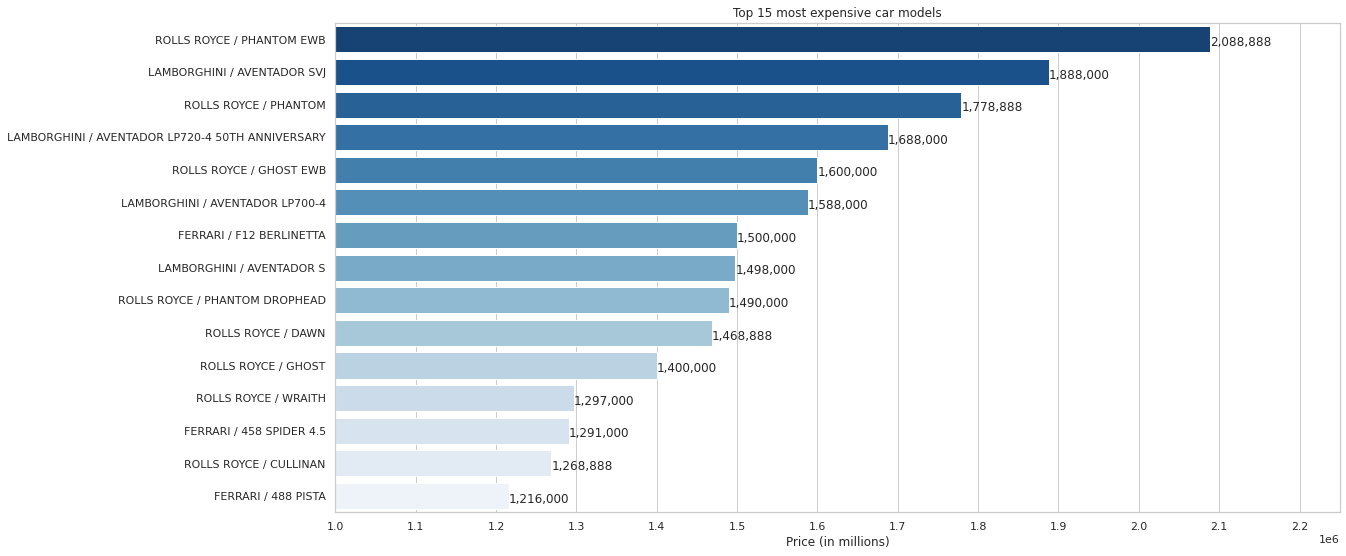

In [9]:
df_prices['Make/Model'] = df_prices['Make'] + ' / ' + df_prices['Model']
prices_top15models = df_prices.sort_values(by='Price', ascending=False)[['Make/Model', 'Price']][:15]

fig, ax = plt.subplots(figsize=(18, 9))
sns.barplot(
    prices_top15models['Price'],
    prices_top15models['Make/Model'],
    orient='h',
    palette='Blues_r',
    ax=ax)
ax.set(
    title='Top 15 most expensive car models',
    ylabel='',
    xlabel='Price (in millions)',
    xlim=[1000000, 2250000],
    xticks=np.arange(1000000, 2300000, step=100000))
graph.show_values_on_bars(ax, 'h')

#### Which are the most expensive car brands?

It is again evident that *ROLLS ROYCE* is the undisputed champion here.

Let us see how the other car brands stack up in comparison.

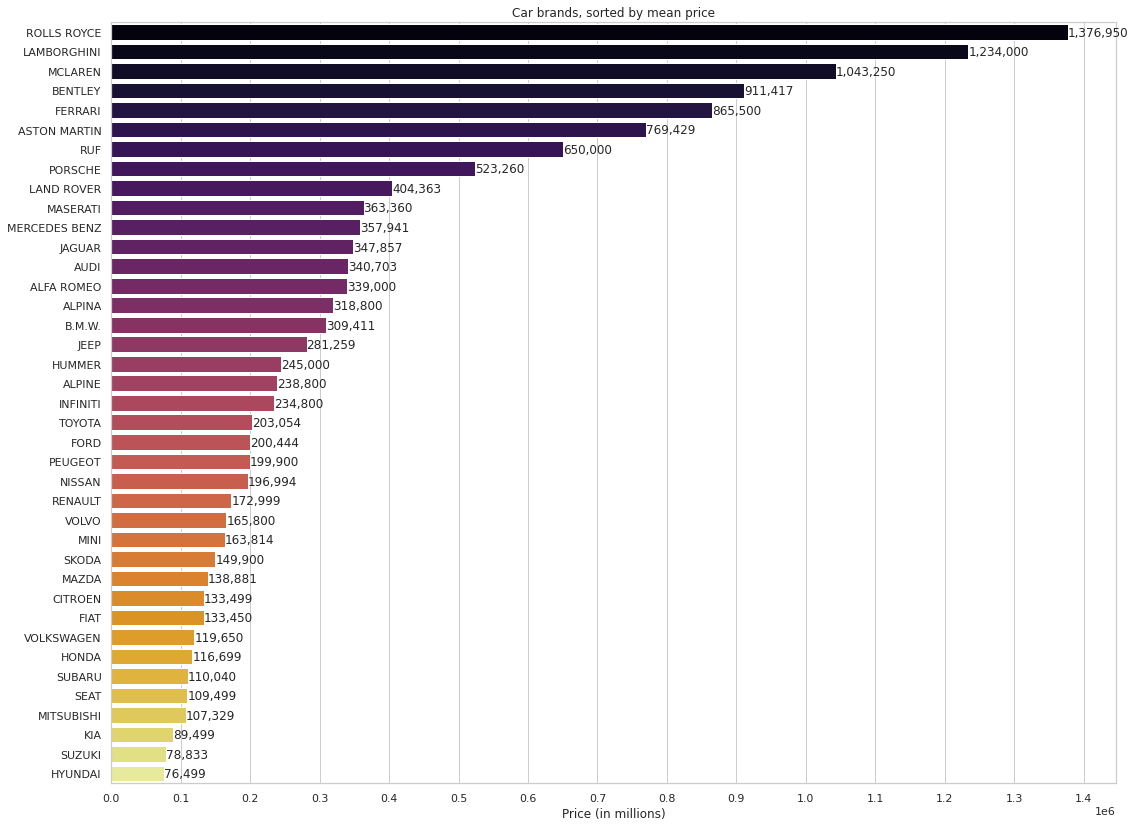

In [10]:
prices_mean_by_brand = df_prices.groupby('Make')['Price'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(18, 14))
sns.barplot(
    x=prices_mean_by_brand.values,
    y=prices_mean_by_brand.index,
    orient='h',
    palette='inferno',
    ax=ax)
ax.set(
    title='Car brands, sorted by mean price',
    xlabel='Price (in millions)',
    ylabel='',
    xticks=np.arange(0, 1500000, step=100000))
graph.show_values_on_bars(ax, 'h')

#### What is the distribution of car prices for each brand?

Some brands have a very large price range in their car offerings - an example is Nissan, where the models range from the humble \\$83k Sylphy to the sporty \\$590k GT-R.

Let us view the price distribution for each brand as well in addition to the order depicted in the above graph for a better overall picture.

*Note: car brands with <=3 models are filtered out to reduce the clutter*

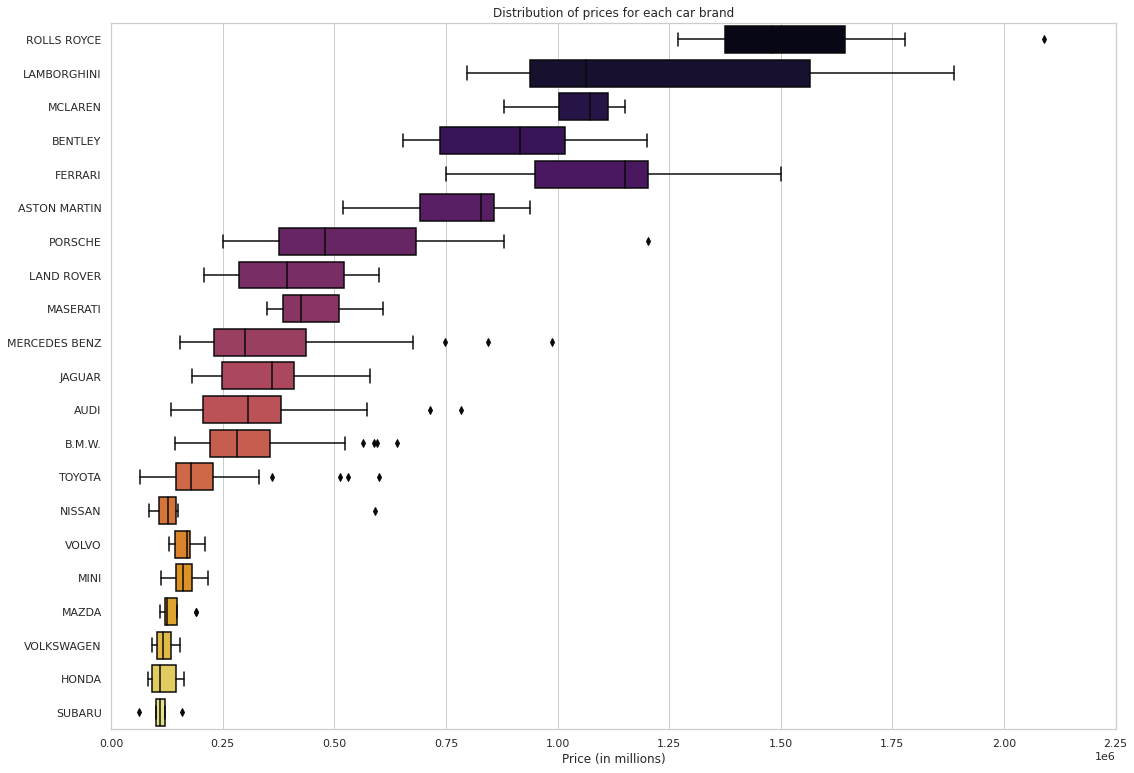

In [11]:
df_prices_fil = df_prices[df_prices.groupby('Make')['Make'].transform(len) > 3]

fig, ax = plt.subplots(figsize=(18, 13))
sns.boxplot(
    df_prices_fil[df_prices_fil['Price'] != 0]['Price'],
    df_prices_fil['Make'],
    order=prices_mean_by_brand.index[prices_mean_by_brand.index.isin(df_prices_fil['Make'])],
    orient='h',
    palette='inferno',
    ax=ax)
ax.set(
    title='Distribution of prices for each car brand',
    xlabel='Price (in millions)',
    ylabel='',
    xlim=[0, 2250000],
    xticks=np.arange(0, 2500000, step=250000));

- As noted above, *NISSAN GT-R* is a significant outlier compared to the rest of the Nissan lineup
- *TOYOTA* has quite a few models above \\$500k, but those belong to the *LEXUS* arm which can be slightly misleading
- *MERCEDES-BENZ* has a very large range, from the \\$150k A-class to the ~\\$1m SLS AMG coupe
- To some surprise, *LAMBORGHINI* has the largest IQR, although the effect is diminished at that price range - the spread from \\$200k to \\$1m is much more impactful than that from \\$1m to \\$1.8m
- The most expensive *AUDI* (*R8 5.2*) costs less than the cheapest *MCLAREN* (*600LT*)...

Let us remove the 5 outlier brands at the top - *ROLLS ROYCE*, *LAMBORGHINI*, *MCLAREN*, *BENTLEY*, *FERRARI* - and examine the detailed distribution of the rest in a swarmplot.

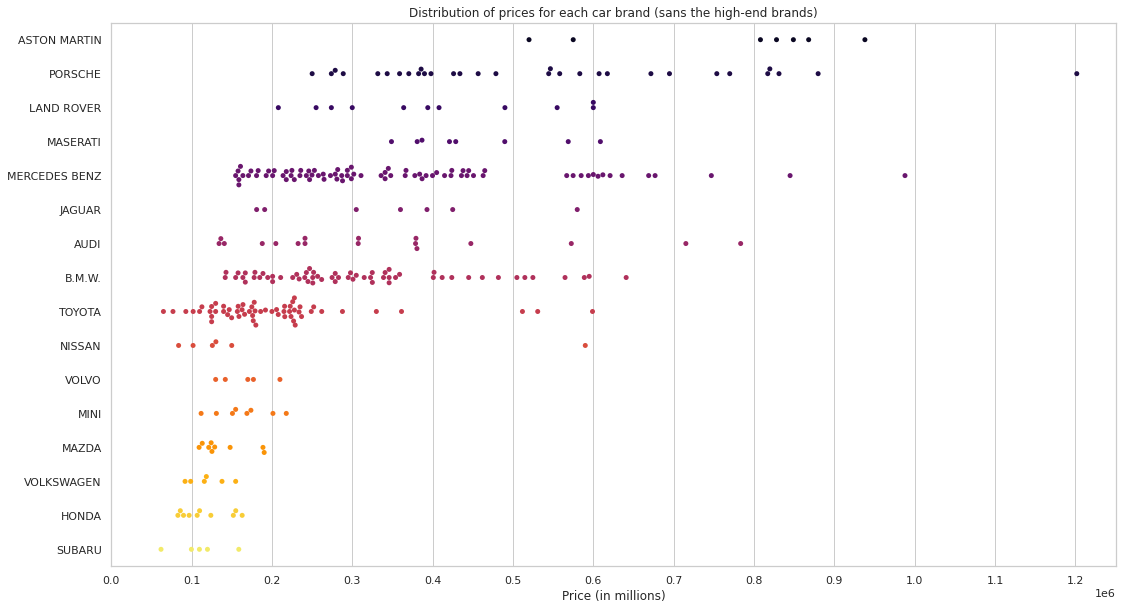

In [12]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.swarmplot(
    df_prices_fil[df_prices_fil['Price'] != 0]['Price'],
    df_prices_fil['Make'],
    order=prices_mean_by_brand.index[prices_mean_by_brand.index.isin(df_prices_fil['Make'])][5:],
    orient='h',
    palette='inferno',
    ax=ax)
ax.set(
    title='Distribution of prices for each car brand (sans the high-end brands)',
    xlabel='Price (in millions)',
    ylabel='',
    xlim=[0, 1250000],
    xticks=np.arange(0, 1300000, step=100000));

- Each dot represents one car model, but the number of unique models is not necessarily indicative of the brand's popularity; instead, it might just be because there are so many models that have only marginal differences
    - e.g. *MERCEDES BENZ* has the following:
        - *GLC250 4MATIC*
        - *GLC250 4MATIC COUPE*
        - *GLC250 AMG 4MATIC*
        - *GLC250 AMG 4MATIC COUPE*
    - e.g. *B.M.W.* has the following:
        - *X5 M-SPORT*
        - *X5 M50D*
        - *X5 XDRIVE25D M-SPORT*
        - *X5 XDRIVE35I*
        - *X5 XDRIVE40I M-SPORT*
    - e.g. *TOYOTA* has the following:
        - *ALPHARD 2.5 ELEGANCE*
        - *ALPHARD 2.5 S*
        - *ALPHARD 2.5 S-A*
        - *ALPHARD 2.5 S-C*
        - *ALPHARD 2.5 X*
- The sole car above the million-dollar mark in this reduced dataset is the *PORSCHE 911 GT2 RS*
- Some brands have notable outliers in their car offerings:
    - *PORSCHE*: *911 GT2 RS*
    - *MERCEDES*: *SLS AMG COUPE*, *MAYBACH S650*
    - *AUDI*: *R8 4.2*, *R8 5.2*
    - *TOYOTA*: *LEXUS LC-* and *LS-*series
    - *NISSAN*: *GT-R*

#### Which are the most popular car brands?

"Most popular car brand" might be a misnomer given the domain of high-value number plates that we are operating in here.

A more accurate phrasing might be "Which car brands are most popular amongst people who favour these high-value numbers?"

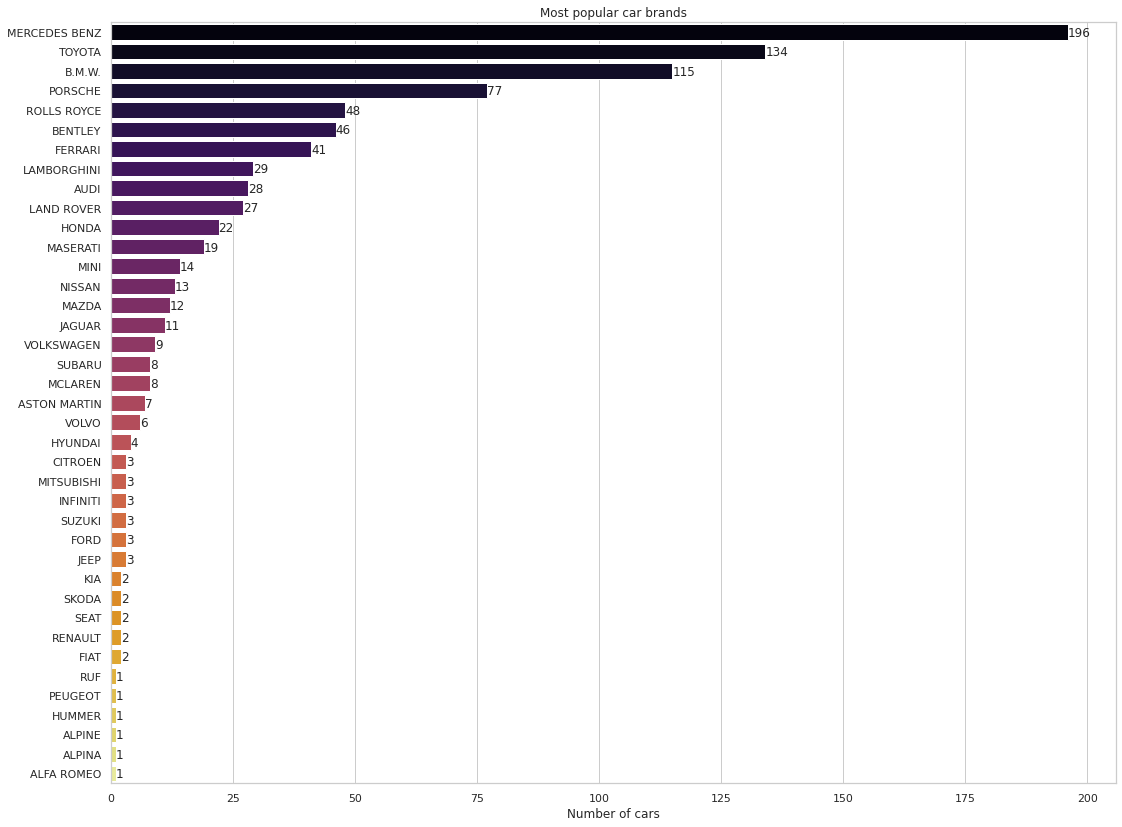

In [13]:
df_popular_brands = df_vrn.unstack().reset_index().drop(['level_0', 'Series'], axis=1)
df_popular_brands = df_popular_brands[df_popular_brands[0] != '-']
df_popular_brands['brand'] = df_popular_brands[0].apply(lambda x: x.split(' / ')[0])
df_popular_brands_series = df_popular_brands.groupby('brand').size().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(18, 14))
sns.barplot(
    x=df_popular_brands_series.values,
    y=df_popular_brands_series.index,
    orient='h',
    palette='inferno',
    ax=ax)
ax.set(
    title='Most popular car brands',
    xlabel='Number of cars',
    ylabel='');
graph.show_values_on_bars(ax, 'h')

- *MERCEDES BENZ* is the best-selling luxury car brand in the world, and it is reflected in this dataset as well
- *TOYOTA* is probably over-represented in this data as it includes *LEXUS* cars as well - might be worth exploring to separate between the 2 for a more representative view
- *ROLLS ROYCE* is the most-represented super luxury car brand - there are many wealthy people around...
- Thanks to this project, I learnt of the existence of these brands *ALPINA*, *ALPINE*, *RUF*

#### Which are the most popular car models?

*MERCEDES BENZ* is by far the most popular car brand.

What if we drill down 1 level to find the 20 most popular car models?

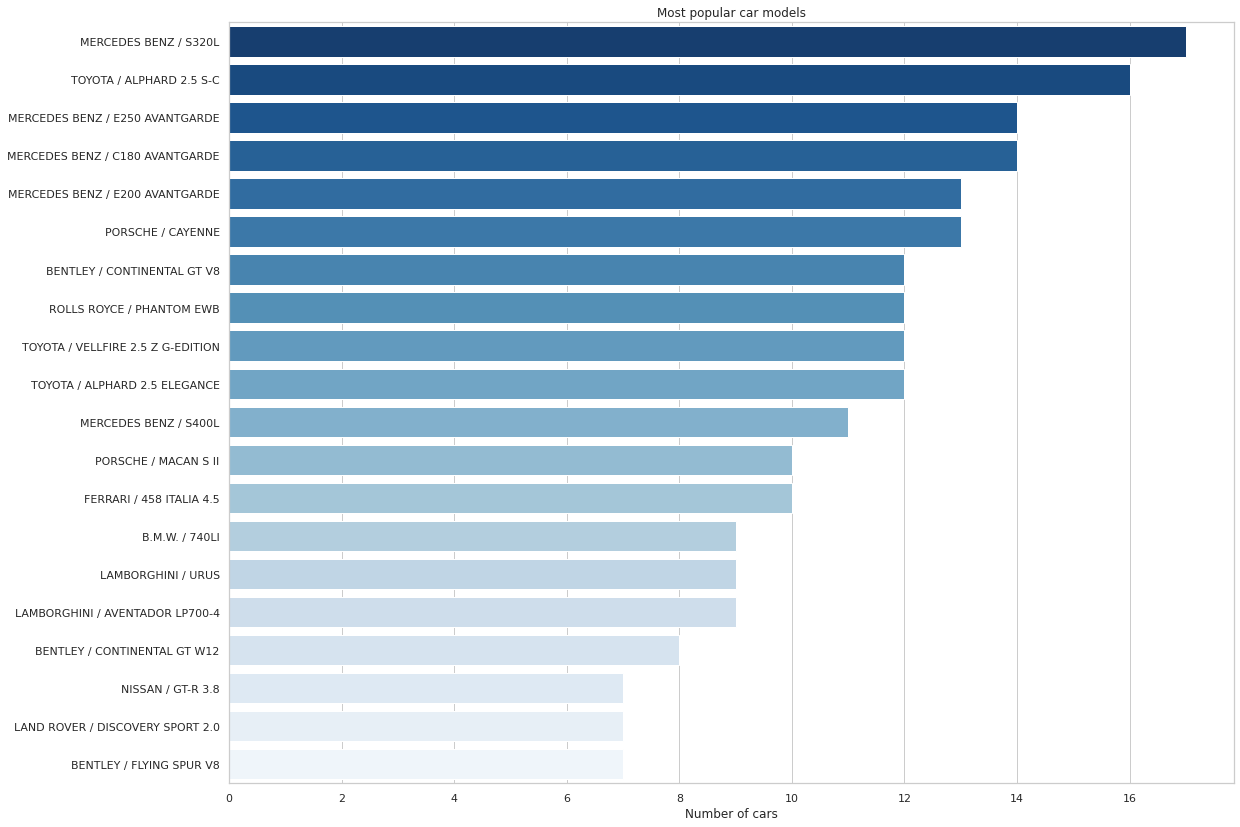

In [14]:
df_popular_models_series = df_popular_brands.groupby(0).size().sort_values(ascending=False)[:20]

fig, ax = plt.subplots(figsize=(18, 14))
sns.barplot(
    x=df_popular_models_series.values,
    y=df_popular_models_series.index,
    orient='h',
    palette='Blues_r',
    ax=ax)
ax.set(
    title='Most popular car models',
    xlabel='Number of cars',
    ylabel='');

- *MERCEDES BENZ* dominates the landscape here too (understandably so), making up 4 of the top 5
- *TOYOTA ALPHARD* is somewhat surprisingly well-represented here, making up 2 of the top 10; in fact, if both were combined under a common *TOYOTA ALPHARD* umbrella, it would rank #1 on this list
- Somewhat surprisingly as well, the joint-most popular Lamborghini is the SUV *LAMBORGHINI URUS*, not what most people think of when they imagine a Lamborghini
- The \\$2.2m *ROLLS ROYCE PHANTOM EWB* is the most popular Rolls - there are indeed many wealthy people around...

## Summary

Some nuggets to take away from this analysis:
- Higher value of a number plate might not necessarily indicate a higher desirability
- Although, based on how the number 4 is a relative outlier to the other single-digit numbers, a lower value *might* have some correlation with a lower desirability
- Single-digit numbers are the king in terms of value
- Rolls-Royce cars are the top 1% of the top 1%
- Singaporeans really like their Mercedes cars


Further improvements to make:
- Separate between *TOYOTA* and *LEXUS* to avoid over-representation of the *TOYOTA* brand
- More data always makes for a more comprehensive analysis